# Generating fake mnist digits using GAN

https://arxiv.org/pdf/1406.2661.pdf

https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/03-advanced/generative_adversarial_network/main.py


## Import libraries

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from torchvision.utils import save_image

## Load Data
* Define constants
* Load mnist and apply transforms
* Define dataloader

In [3]:
batch_size = 100

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,))])

In [5]:
mnist = torchvision.datasets.MNIST(root='datasets/',
                                   train=True,
                                   transform=transform,
                                   download=True)

In [6]:
data_loader = torch.utils.data.DataLoader(dataset=mnist,
                                          batch_size=batch_size, 
                                          shuffle=True)

## Visualize Data

In [7]:
images, labels = iter(data_loader).next()

In [8]:
images

tensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        ...,


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., 

In [9]:
labels

tensor([0, 7, 1, 0, 5, 8, 2, 6, 3, 5, 4, 9, 9, 0, 9, 8, 1, 8, 7, 1, 3, 9, 8, 3,
        2, 3, 3, 3, 9, 2, 9, 2, 5, 9, 2, 0, 4, 4, 2, 7, 2, 6, 3, 0, 1, 3, 3, 4,
        8, 3, 0, 9, 5, 6, 4, 1, 9, 4, 5, 3, 9, 0, 4, 8, 3, 1, 8, 7, 2, 2, 4, 0,
        6, 6, 2, 4, 0, 8, 8, 2, 2, 7, 8, 5, 7, 7, 7, 9, 2, 2, 4, 3, 9, 8, 2, 1,
        1, 4, 9, 2])

In [7]:
img = torchvision.utils.make_grid(images)

In [8]:
img = img.detach().numpy()
img = img.clip(0,1)

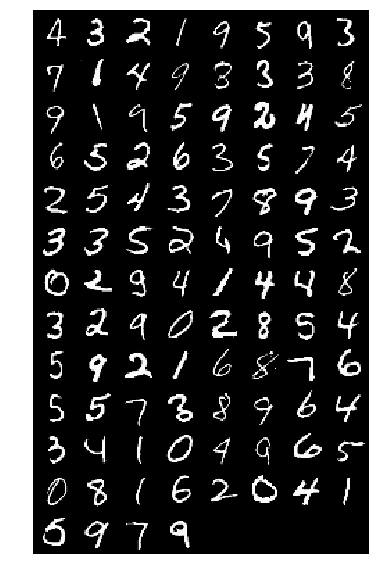

In [9]:
plt.figure(figsize = (12,10))
plt.imshow(np.transpose(img, (1,2,0)))
plt.axis('off')
plt.show()

## Define Neural Networks
* Define Hyper-parameters
* Define the Discriminator
* Define the Generator 



In [10]:
latent_size = 64
hidden_size = 256
image_size = 784
num_epochs = 100

In [11]:
D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Dropout(0.5),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Dropout(0.5),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())

In [12]:
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())

In [13]:
D = D.to(device)
G = G.to(device)

## Training

In [14]:
bce_loss = nn.BCELoss()

d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

In [15]:
total_step = len(data_loader)

In [16]:
for epoch in range(num_epochs):
    
    for i, (images, _) in enumerate(data_loader):
        
        images = images.reshape(batch_size, -1).to(device)
        
        # Create the labels which are later used as input for the BCE loss
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # ================================================================== #
        #                      Train the discriminator                       #
        # ================================================================== #

        # Compute BCE_Loss using real images where BCE_Loss(x, y): - y * log(D(x)) - (1-y) * log(1 - D(x))
        
        outputs = D(images)

        # Second term of the loss is always zero since real_labels == 1
        # This is what causes it to minimize the loss for real images
        d_loss_real = bce_loss(outputs, real_labels)
        real_score = outputs
        
        # Compute BCELoss using fake images
        
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        
        outputs = D(fake_images)

        # First term of the loss is always zero since fake_labels == 0
        # This is what causes it to maximize the loss for fake images
        d_loss_fake = bce_loss(outputs, fake_labels)
        fake_score = outputs
        
        # Backprop and optimize
        d_loss = d_loss_real + d_loss_fake
        
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        
        d_loss.backward()
        d_optimizer.step()
        
        # ================================================================== #
        #                        Train the generator                         #
        # ================================================================== #

        # Compute loss with fake images
        
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)
        
        # We train G to maximize log(D(G(z)) instead of minimizing log(1-D(G(z)))
        # For the reason, see the last paragraph of section 3. https://arxiv.org/pdf/1406.2661.pdf
        
        g_loss = bce_loss(outputs, real_labels)
        
        # Backprop and optimize
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()

        g_loss.backward()
        g_optimizer.step()
        
        if (i+1) % 200 == 0:
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
    
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)

Epoch [0/100], Step [200/600], d_loss: 0.1183, g_loss: 4.4201, D(x): 0.97, D(G(z)): 0.08
Epoch [0/100], Step [400/600], d_loss: 0.5738, g_loss: 2.7716, D(x): 0.88, D(G(z)): 0.26
Epoch [0/100], Step [600/600], d_loss: 0.6947, g_loss: 1.6829, D(x): 0.77, D(G(z)): 0.29
Epoch [1/100], Step [200/600], d_loss: 0.9062, g_loss: 2.3809, D(x): 0.70, D(G(z)): 0.29
Epoch [1/100], Step [400/600], d_loss: 0.7590, g_loss: 1.6480, D(x): 0.80, D(G(z)): 0.33
Epoch [1/100], Step [600/600], d_loss: 1.3575, g_loss: 0.6865, D(x): 0.66, D(G(z)): 0.54
Epoch [2/100], Step [200/600], d_loss: 0.9628, g_loss: 1.3068, D(x): 0.72, D(G(z)): 0.37
Epoch [2/100], Step [400/600], d_loss: 0.8802, g_loss: 1.4836, D(x): 0.73, D(G(z)): 0.26
Epoch [2/100], Step [600/600], d_loss: 0.6985, g_loss: 2.0883, D(x): 0.79, D(G(z)): 0.24
Epoch [3/100], Step [200/600], d_loss: 0.5743, g_loss: 1.8450, D(x): 0.83, D(G(z)): 0.24
Epoch [3/100], Step [400/600], d_loss: 0.9317, g_loss: 1.6019, D(x): 0.71, D(G(z)): 0.26
Epoch [3/100], Step [

## Visualize Results

In [17]:
img = torchvision.utils.make_grid(fake_images)

In [19]:
img = img.detach().cpu().numpy()
img = img.clip(0,1)

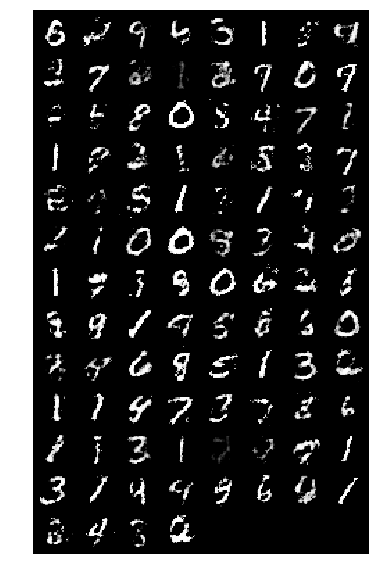

In [20]:
plt.figure(figsize = (12, 10))
plt.imshow(np.transpose(img, (1, 2, 0)))
plt.axis('off')
plt.show()